# DIVOT using debiasing functions

In [1]:
from util import *
from jax import grad, value_and_grad, jit,vmap, random
import sys


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/jax/config.py:163: UserWarning: enable_omnistaging() is a no-op in JAX versions 0.2.12 and higher;
see https://github.com/google/jax/blob/master/design_notes/omnistaging.md
  "enable_omnistaging() is a no-op in JAX versions 0.2.12 and higher;\n"


In [2]:
@jit
def loss_jax(params, df_batch,un):
    x,y = df_batch[:,0],df_batch[:,1]
    vec = jnp.sort(y-params['w']*x) - jnp.sort(params['theta']*un)
    return jnp.var(vec)

val_and_grad = value_and_grad(loss_jax)
vmap_val_and_grad_inner = vmap(val_and_grad, in_axes=(None,None,1),out_axes=0)  
vmap_val_and_grad_outer = vmap(vmap_val_and_grad_inner, in_axes=(None,0,2),out_axes=0)  
vmap_val_and_grad_outer = jit(vmap_val_and_grad_outer)

In [3]:
def batch_test(df,resolution,npos):
    nghM = get_neighbor_matrix_fixed_num(df, resolution)
    batches = get_batches(data=df, neighborM=nghM, resolution=resolution, npos=npos)
    batches = jnp.array(batches)

    df_batch = batches[0]
    batch_sz,_ = df_batch.shape
    return batches,batch_sz

In [4]:
def test(batches,key_seed=42,step_sz = 1.0,exp = 200,nrep = 100):
    key = random.PRNGKey(key_seed)
    df_batch = batches[0]
    batch_sz,_ = df_batch.shape
    
    theta =0.2
    w = 0.1
    params = {'w': w, 'theta':theta}

    loss_res = []
    params_res = []
    w_res = []
    t_res = []
    gradt_res = []
    gradw_res = []

    for j in range(exp):
        
        key, subkey = random.split(key)
        un = random.uniform(subkey,shape=(batch_sz,nrep,len(batches)),minval=0.0, maxval=1.0)
        loss_val,grad = vmap_val_and_grad_outer(params, batches, un)

        ave_loss = np.mean(loss_val)
        ave_grad = tree_map(np.mean, grad)

        params['w'] -= 1*step_sz * ave_grad['w']
        params['theta'] -= step_sz * ave_grad['theta']

        loss_res.append(ave_loss)
        w_res.append(params['w'])
        t_res.append(params['theta'])
        gradw_res.append(ave_grad['w'])
        gradt_res.append(ave_grad['theta'])
        if j%10==0:
            sys.stdout.write("\rDoing thing %i" % j)  
    return loss_res,w_res,t_res,gradw_res,gradt_res

# Data generation

In [5]:
# Set problem dimensions
nsamples = 100
resolution = 0.6
npos = 100

def f_t(x):
    # if x < 0:
    #     return 0.5*x**3 -x
    # else:   
    #     return 1 - 0.5*x**3 + x
    return 1.0*x
    # return jnp.sin(4*x)

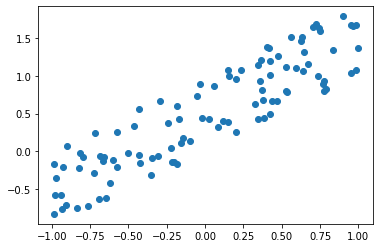

In [6]:
# Generate random ground truth W and b
key = random.PRNGKey(10)
k1, k2 = random.split(key)

# Generate samples with additional noise
ksample, knoise = random.split(k1)
x_samples = random.uniform(k1,shape=(nsamples, 1),minval=-1, maxval=1)

y_samples = np.array([f_t(x) for x in x_samples])
y_samples += 1.0*random.uniform(knoise,shape=(nsamples, 1),minval=0.0, maxval=1.0)
x= x_samples.reshape(-1)
y= y_samples.reshape(-1)
plt.scatter(x,y)

n = nsamples
df_c = np.zeros([n,2])
df_c[:,0],df_c[:,1] = x,y
df_sort_c = sortBycol(df_c,0)

df_rv = np.zeros([n,2])
df_rv[:,0],df_rv[:,1] = y,x
df_sort_rv = sortBycol(df_rv,0)

# Compute the minimal variance-based divergence measure in both directions

In [7]:
c_batches,c_batch_sz = batch_test(df_sort_c,resolution,npos)

c_loss_res, c_w_res,c_t_res,c_gradw_res,c_gradt_res= test(c_batches, key_seed = 42, step_sz =1.0, exp = 100,nrep = 50)
loss_c = np.mean(c_loss_res[-10:])/np.mean(c_t_res[-10:])**2

rv_batches,rv_batch_sz = batch_test(df_sort_rv,resolution,npos)
rv_loss_res, rv_w_res,rv_t_res,rv_gradw_res,rv_gradt_res= test(rv_batches,key_seed = 42, step_sz = 1.0, exp = 100,nrep = 50)
loss_rv = np.mean(rv_loss_res[-10:])/np.mean(rv_t_res[-10:])**2

Doing thing 90

## In the causal direction

0.002471824999201209


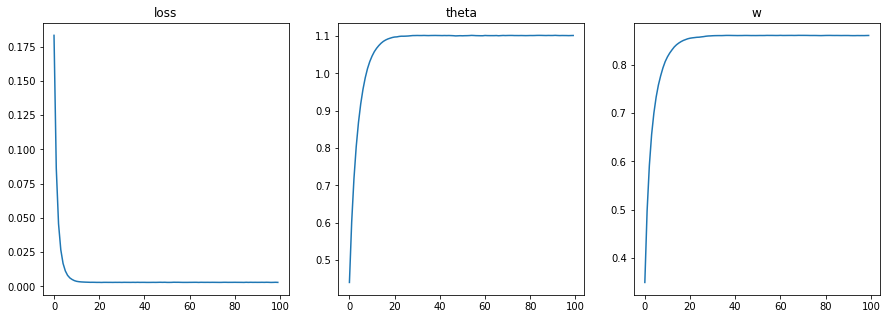

In [8]:
print(loss_c)
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('loss')
plt.plot(np.arange(0,len(c_loss_res),1), c_loss_res)

plt.subplot(1,3,2)
plt.title('theta')
plt.plot(np.arange(0,len(c_t_res),1), c_t_res)

plt.subplot(1,3,3)
plt.title('w')
plt.plot(np.arange(0,len( c_w_res),1), c_w_res)

## In the reverse direction

0.002500314981683979


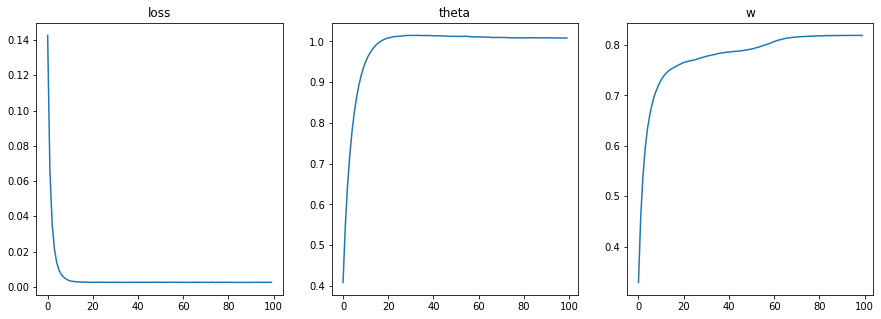

In [9]:
print(loss_rv)
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('loss')
plt.plot(np.arange(0,len(rv_loss_res),1), rv_loss_res)

plt.subplot(1,3,2)
plt.title('theta')
plt.plot(np.arange(0,len(rv_t_res),1), rv_t_res)

plt.subplot(1,3,3)
plt.title('w')
plt.plot(np.arange(0,len( rv_w_res),1), rv_w_res) 